# Import Required Libraries
using CSV
using DataFrames
using Statistics
using StatsBase
using Plots

In [2]:
using CSV
using DataFrames
using Statistics
using StatsBase
using Plots

# Define Helper Functions


In [5]:
# Función para calcular el porcentaje de valores faltantes por columna
# @param df: DataFrame
# @return: Diccionario con el nombre de la columna como clave y el porcentaje de valores faltantes como valor
function porcentaje_faltantes(df::DataFrame)
    porcentajes_faltantes = Dict()
    for col in names(df)
        conteo_faltantes = count(ismissing, df[:, col])
        porcentajes_faltantes[col] = (conteo_faltantes / nrow(df)) * 100
    end
    return porcentajes_faltantes
end

porcentaje_faltantes (generic function with 1 method)

In [6]:
# Función para eliminar columnas con un porcentaje de valores faltantes mayor al umbral
# @param df: DataFrame
# @param umbral: Umbral de porcentaje de valores faltantes para eliminar columnas
# @return: DataFrame con las columnas que tienen un porcentaje de valores faltantes menor o igual al umbral
function eliminar_columnas(df::DataFrame, umbral::Float64)
    println("Eliminando columnas con porcentaje de valores faltantes mayor al umbral $umbral...")
    porcentajes_faltantes = porcentaje_faltantes(df)
    columnas_a_conservar = filter(col -> porcentajes_faltantes[col] <= umbral, names(df))
    println("Columnas conservadas: ", columnas_a_conservar)
    return df[:, columnas_a_conservar]
end

eliminar_columnas (generic function with 1 method)

In [7]:
# Función para calcular la matriz de correlación
# @param df: DataFrame
# @return: Matriz de correlación y nombres de las columnas numéricas
function calcular_correlacion(df::DataFrame)
    println("Calculando matriz de correlación...")
    columnas_numericas = filter(c -> eltype(df[!, c]) <: Number, names(df))
    df_numerico = df[:, columnas_numericas]
    matriz_correlacion = pairwise(cor, eachcol(df_numerico))
    println("Matriz de correlación:")
    println(matriz_correlacion)
    return matriz_correlacion, columnas_numericas
end

calcular_correlacion (generic function with 1 method)

In [8]:
# Función para mostrar la matriz de correlación como un mapa de calor
# @param matriz_correlacion: Matriz de correlación
# @param nombres_columnas: Nombres de las columnas
function mostrar_correlacion(matriz_correlacion, nombres_columnas)
    println("Mostrando mapa de calor de la matriz de correlación...")
    heatmap(
        matriz_correlacion,
        xticks=(1:length(nombres_columnas), nombres_columnas),
        yticks=(1:length(nombres_columnas), nombres_columnas),
        color=:coolwarm,
        title="Mapa de Calor de Correlación",
        xlabel="Variables",
        ylabel="Variables"
    )
end

mostrar_correlacion (generic function with 1 method)

In [9]:
# Función para eliminar outliers usando el IQR
# @param df: DataFrame
function eliminar_outliers_IQR!(df::DataFrame)
    println("Eliminando outliers usando IQR...")
    columnas_numericas = filter(c -> eltype(df[!, c]) <: Number, names(df))
    for col in columnas_numericas
        Q1 = quantile(skipmissing(df[!, col]), 0.25)
        Q3 = quantile(skipmissing(df[!, col]), 0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        df[!, col] = [x < limite_inferior || x > limite_superior ? missing : x for x in df[!, col]]
    end
    println("Outliers reemplazados con valores faltantes.")
end

eliminar_outliers_IQR! (generic function with 1 method)

In [10]:
# Función para eliminar filas con valores nulos en una columna específica
# @param df: DataFrame
# @param columna: Nombre de la columna
# @return: DataFrame sin filas que tienen valores nulos en la columna especificada
function eliminar_filas_con_nulos(df::DataFrame, columna::Symbol)
    println("Eliminando filas con valores nulos en la columna $columna...")
    nuevo_df = dropmissing(df, [columna])
    println("Filas restantes: ", nrow(nuevo_df))
    return nuevo_df
end

eliminar_filas_con_nulos (generic function with 1 method)

In [11]:
# Función para filtrar columnas según la correlación con una columna objetivo
# @param df: DataFrame
# @param objetivo: Nombre de la columna objetivo
# @param umbral: Umbral de correlación
# @param relacion: Relación de correlación ("mayor" o "menor")
# @return: DataFrame con las columnas filtradas
function filtrar_columnas_por_correlacion(df::DataFrame, objetivo::Symbol, umbral::Float64, relacion::String)
    println("Filtrando columnas según la correlación con $objetivo (umbral: $umbral, relación: $relacion)...")
    columnas_numericas = filter(c -> eltype(df[!, c]) <: Number, names(df))
    correlaciones = Dict(col => cor(skipmissing(df[!, objetivo]), skipmissing(df[!, col])) for col in columnas_numericas if col != objetivo)
    if relacion == "mayor"
        columnas_filtradas = filter(col -> correlaciones[col] > umbral, keys(correlaciones))
    elseif relacion == "menor"
        columnas_filtradas = filter(col -> correlaciones[col] < umbral, keys(correlaciones))
    else
        error("La relación debe ser 'mayor' o 'menor'.")
    end
    println("Columnas filtradas: ", columnas_filtradas)
    return df[:, vcat(objetivo, collect(columnas_filtradas))]
end

filtrar_columnas_por_correlacion (generic function with 1 method)

In [12]:
# Función para mostrar estadísticas descriptivas de cada columna
# @param df: DataFrame
function describir_datos(df::DataFrame)
    println("Estadísticas descriptivas de cada columna:")
    println(describe(df))
end

describir_datos (generic function with 1 method)

# Load Dataset

In [16]:
# Load Dataset
println("Cargando dataset...")
df = CSV.read("julia/src/student_submissions/exploratory_data_analysis/aleman_juan/eda_aleman_juan/exercise_one/data/bottle.csv", DataFrame)

Cargando dataset...


Row,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,RecInd,T_prec,T_qual,S_prec,S_qual,P_qual,O_qual,SThtaq,O2Satq,ChlorA,Chlqua,Phaeop,Phaqua,PO4uM,PO4q,SiO3uM,SiO3qu,NO2uM,NO2q,NO3uM,NO3q,NH3uM,NH3q,C14As1,C14A1p,C14A1q,C14As2,C14A2p,C14A2q,DarkAs,DarkAp,DarkAq,MeanAs,MeanAp,MeanAq,IncTim,LightP,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_O2,R_O2Sat,R_SIO3,R_PO4,R_NO3,R_NO2,R_NH4,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
,Int64,Int64,String15,String,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64?,Int64,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Int64?,Float64?,Int64?,Int64?,Float64?,Int64?,Int64?,Float64?,Int64?,Int64?,String31?,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String?
1,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.5,33.44,missing,25.649,missing,missing,missing,3,1,missing,2,missing,9,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,0.0,10.5,10.5,33.44,25.64,233.0,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,0,missing,missing,missing,missing,missing,missing,missing,missing
2,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.44,missing,25.656,missing,missing,missing,3,2,missing,2,missing,9,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,8.0,10.46,10.46,33.44,25.65,232.5,0.01,missing,missing,missing,missing,missing,missing,missing,missing,missing,8,missing,missing,missing,missing,missing,missing,missing,missing
3,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,missing,25.654,missing,missing,missing,7,2,missing,3,missing,9,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,10.0,10.46,10.46,33.437,25.65,232.8,0.02,missing,missing,missing,missing,missing,missing,missing,missing,missing,10,missing,missing,missing,missing,missing,missing,missing,missing
4,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.42,missing,25.643,missing,missing,missing,3,2,missing,2,missing,9,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,19.0,10.45,10.45,33.42,25.64,234.1,0.04,missing,missing,missing,missing,missing,missing,missing,missing,missing,19,missing,missing,missing,missing,missing,missing,missing,missing
5,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,missing,25.643,missing,missing,missing,7,2,missing,3,missing,9,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,20.0,10.45,10.45,33.421,25.64,234.0,0.04,missing,missing,missing,missing,missing,missing,missing,missing,missing,20,missing,missing,missing,missing,missing,missing,missing,missing
6,1,6,054.0 056.0,19-4903CR-HY-060-0930-05400560-0030A-7,30,10.45,33.431,missing,25.651,missing,missing,missing,7,2,missing,3,missing,9,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,9,missing,missing,30.0,10.45,10.45,33.431,25.65,233.5,0.07,missing,missing,missing,missing,missing,missing,missing,missing,missing,30,missing,missing,missing,missing,missing,missin

# Show Dataset Dimensions

In [29]:
# Show Dataset Dimensions
println("Dimensiones del dataset: ", size(df))

Dimensiones del dataset: (864863, 74)


# Show Data Types of Each Column
println("Tipos de datos de cada columna:")
for col in names(df)
    println("$col: $(eltype(df[!, col]))")
end

In [30]:
# Show Data Types of Each Column
println("Tipos de datos de cada columna:")
for col in names(df)
    println("$col: $(eltype(df[!, col]))")
end

Tipos de datos de cada columna:
Cst_Cnt: Int64
Btl_Cnt: Int64
Sta_ID: String15
Depth_ID: String
Depthm: Int64
T_degC: Union{Missing, Float64}
Salnty: Union{Missing, Float64}
O2ml_L: Union{Missing, Float64}
STheta: Union{Missing, Float64}
O2Sat: Union{Missing, Float64}
Oxy_µmol/Kg: Union{Missing, Float64}
BtlNum: Union{Missing, Int64}
RecInd: Int64
T_prec: Union{Missing, Int64}
T_qual: Union{Missing, Int64}
S_prec: Union{Missing, Int64}
S_qual: Union{Missing, Int64}
P_qual: Union{Missing, Int64}
O_qual: Union{Missing, Int64}
SThtaq: Union{Missing, Int64}
O2Satq: Union{Missing, Int64}
ChlorA: Union{Missing, Float64}
Chlqua: Union{Missing, Int64}
Phaeop: Union{Missing, Float64}
Phaqua: Union{Missing, Int64}
PO4uM: Union{Missing, Float64}
PO4q: Union{Missing, Int64}
SiO3uM: Union{Missing, Float64}
SiO3qu: Union{Missing, Int64}
NO2uM: Union{Missing, Float64}
NO2q: Union{Missing, Int64}
NO3uM: Union{Missing, Float64}
NO3q: Union{Missing, Int64}
NH3uM: Union{Missing, Float64}
NH3q: Union{Miss

# Count and Show Missing Values

In [31]:
# Calculate the percentage of missing values per column
println("Porcentaje de valores faltantes por columna:")
porcentajes_faltantes = porcentaje_faltantes(df)
for (col, perc) in porcentajes_faltantes
    println("$col: $perc%")
end

Porcentaje de valores faltantes por columna:
pH2: 99.99884374750683%
SiO3uM: 59.058139844114045%
LightP: 97.84347347498968%
MeanAp: 97.63465427472327%
Cst_Cnt: 0.0%
TA2: 99.97294369165984%
R_O2: 19.501585800294382%
R_DYNHT: 5.394727257380649%
TA1: 99.75903698042349%
O2Satq: 74.81716757451758%
DarkAs: 97.38120372822054%
PO4q: 47.76213111209521%
R_SVA: 6.101660031704443%
NH3q: 6.540226602363611%
R_NO3: 60.98676900272066%
T_qual: 97.32593485904704%
R_SALINITY: 5.475318056154559%
O2ml_L: 19.501585800294382%
S_prec: 5.475318056154559%
STheta: 6.092178761260454%
Phaqua: 26.095809394089002%
Phaeop: 73.95298446112274%
IncTim: 98.33071827561129%
Sta_ID: 0.0%
S_qual: 91.33805007267047%
SiO3qu: 40.930991382450166%
R_CHLA: 73.95240633487616%
DIC1: 99.76886512661542%
BtlNum: 86.27909853930622%
DIC2: 99.97409994415301%
R_POTEMP: 5.324195855297313%
NO3q: 38.726364753724%
C14A2q: 1.877754048907168%
O_qual: 78.64679145714408%
DarkAp: 97.63465427472327%
R_O2Sat: 22.941783843221412%
P_qual: 22.0969101464

# Remove Columns with High Missing Values

In [32]:
umbral = 50.0
df_limpio = eliminar_columnas(df, umbral)

Eliminando columnas con porcentaje de valores faltantes mayor al umbral 50.0...
Columnas conservadas: ["Cst_Cnt", "Btl_Cnt", "Sta_ID", "Depth_ID", "Depthm", "T_degC", "Salnty", "O2ml_L", "STheta", "O2Sat", "Oxy_µmol/Kg", "RecInd", "T_prec", "S_prec", "P_qual", "Chlqua", "Phaqua", "PO4q", "SiO3qu", "NO2q", "NO3q", "NH3q", "C14A1q", "C14A2q", "DarkAq", "MeanAq", "R_Depth", "R_TEMP", "R_POTEMP", "R_SALINITY", "R_SIGMA", "R_SVA", "R_DYNHT", "R_O2", "R_O2Sat", "R_PRES"]


Row,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,RecInd,T_prec,S_prec,P_qual,Chlqua,Phaqua,PO4q,SiO3qu,NO2q,NO3q,NH3q,C14A1q,C14A2q,DarkAq,MeanAq,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_O2,R_O2Sat,R_PRES
,Int64,Int64,String15,String,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64
1,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.5,33.44,missing,25.649,missing,missing,3,1,2,9,9,9,9,9,9,9,9,9,9,9,9,0.0,10.5,10.5,33.44,25.64,233.0,0.0,missing,missing,0
2,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.44,missing,25.656,missing,missing,3,2,2,9,9,9,9,9,9,9,9,9,9,9,9,8.0,10.46,10.46,33.44,25.65,232.5,0.01,missing,missing,8
3,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,missing,25.654,missing,missing,7,2,3,9,9,9,9,9,9,9,9,9,9,9,9,10.0,10.46,10.46,33.437,25.65,232.8,0.02,missing,missing,10
4,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.42,missing,25.643,missing,missing,3,2,2,9,9,9,9,9,9,9,9,9,9,9,9,19.0,10.45,10.45,33.42,25.64,234.1,0.04,missing,missing,19
5,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,missing,25.643,missing,missing,7,2,3,9,9,9,9,9,9,9,9,9,9,9,9,20.0,10.45,10.45,33.421,25.64,234.0,0.04,missing,missing,20
6,1,6,054.0 056.0,19-4903CR-HY-060-0930-05400560-0030A-7,30,10.45,33.431,missing,25.651,missing,missing,7,2,3,9,9,9,9,9,9,9,9,9,9,9,9,30.0,10.45,10.45,33.431,25.65,233.5,0.07,missing,missing,30
7,1,7,054.0 056.0,19-4903CR-HY-060-0930-05400560-0039A-3,39,10.45,33.44,missing,25.658,missing,missing,3,2,2,9,9,9,9,9,9,9,9,9,9,9,9,39.0,10.45,10.45,33.44,25.65,233.0,0.09,missing,missing,39
8,1,8,054.0 056.0,19-4903CR-HY-060-0930-05400560-0050A-7,50,10.24,33.424,missing,25.682,missing,missing,7,2,3,9,9,9,9,9,9,9,9,9,9,9,9,50.0,10.24,10.23,33.424,25.68,231.0,0.11,missing,missing,50
9,1,9,054.0 056.0,19-4903CR-HY-060-0930-05400560-0058A-3,58,10.06,33.42,missing,25.71,missing,missing,3,2,2,9,9,9,9,9,9,9,9,9,9,9,9,58.0,10.06,10.05,33.42,25.71,228.5,0.13,missing,missing,58


# Calculate and Show Correlation Matrix

Calculando matriz de correlación...
Matriz de correlación:
[1.0 0.9993450094378055 -0.16222238751808693 -0.10014210235630165 -0.16221971496243476 -0.16196071499218948; 0.9993450094378055 1.0 -0.1616166704273927 -0.1008277193956303 -0.16161392343184408 -0.16134761606703005; -0.16222238751808693 -0.1616166704273927 1.0 0.08231579840320519 0.9999999972818153 0.9999939222785432; -0.10014210235630165 -0.1008277193956303 0.08231579840320519 1.0 0.0823170504943992 0.08218347201427104; -0.16221971496243476 -0.16161392343184408 0.9999999972818153 0.0823170504943992 1.0 0.9999939296557131; -0.16196071499218948 -0.16134761606703005 0.9999939222785432 0.08218347201427104 0.9999939296557131 1.0]
Mostrando mapa de calor de la matriz de correlación...


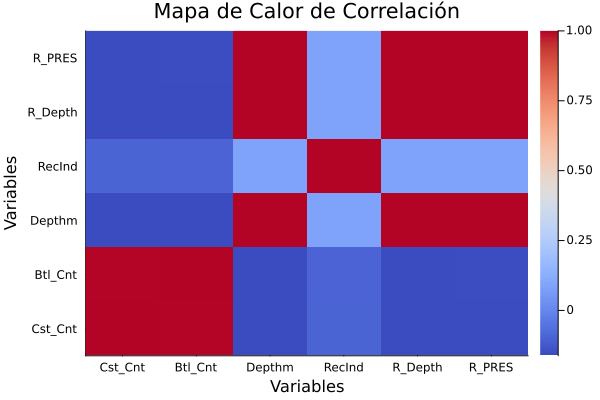

In [33]:
# Calculate the correlation matrix and get the names of numeric columns
matriz_correlacion, nombres_columnas = calcular_correlacion(df_limpio)

# Display the correlation matrix as a heatmap
mostrar_correlacion(matriz_correlacion, nombres_columnas)

# Remove Outliers

In [37]:
# Function to remove outliers using the IQR
# @param df: DataFrame
function eliminar_outliers_IQR!(df::DataFrame)
    println("Eliminando outliers usando IQR...")
    columnas_numericas = filter(c -> eltype(df[!, c]) <: Number, names(df))
    for col in columnas_numericas
        Q1 = quantile(skipmissing(df[!, col]), 0.25)
        Q3 = quantile(skipmissing(df[!, col]), 0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        df[!, col] = [x < limite_inferior || x > limite_superior ? missing : x for x in df[!, col]]
    end
    println("Outliers reemplazados con valores faltantes.")
end

# Example usage
eliminar_outliers_IQR!(df_limpio)

Eliminando outliers usando IQR...
Outliers reemplazados con valores faltantes.


# Remove Rows with Null Values in a Specific Column

In [38]:
# Check if the column :Temperature exists in the DataFrame
if :Temperature in names(df_limpio)
    # Remove rows with null values in the :Temperature column
    df_limpio = eliminar_filas_con_nulos(df_limpio, :Temperature)
end

# Filter Columns by Correlation

In [39]:
# Check if the column :Salinity exists in the DataFrame
if :Salinity in names(df_limpio)
    # Filter columns based on correlation with the :Salinity column
    df_limpio = filtrar_columnas_por_correlacion(df_limpio, :Salinity, 0.7, "mayor")
end

# Show Descriptive Statistics

In [40]:
# Function to display descriptive statistics for each column
# @param df: DataFrame
function describir_datos(df::DataFrame)
    println("Estadísticas descriptivas de cada columna:")
    println(describe(df))
end

# Example usage
describir_datos(df_limpio)

Estadísticas descriptivas de cada columna:
36×7 DataFrame
 Row │ variable     mean      min                                median    max                                nmissing  eltype                  
     │ Symbol       Union…    Any                                Union…    Any                                Int64     Type                    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Cst_Cnt      17138.8   1                                  16848.0   34404                                     0  Int64
   2 │ Btl_Cnt      432432.0  1                                  432432.0  864863                                    0  Int64
   3 │ Sta_ID                 001.0 168.0                                  176.7 030.0                               0  String15
   4 │ Depth_ID               19-4903CR-HY-060-0930-05400560-0…            20-1611SR-PR-324-1700-07670700-0…         0  String